In [1]:
pip install xgboost lightgbm

In [2]:
#Importando la biblioteca Pandas
import pandas as pd

#Importando el módulo JSON
import json

# Import requests to fetch data from URL
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io


# import para modelos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, f1_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc



from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost as xgb
from lightgbm import LGBMClassifier

In [3]:
# @title Data Set
path = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json'

# Fetch the data from the URL
response = requests.get(path)
data = json.loads(response.text)

# Normalize the JSON data
df_normalized = pd.json_normalize(data)

# Display the first few rows of the normalized DataFrame
display(df_normalized.head())


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [4]:
# @title Diccionario de variables
"""
Variables de Entrada:

Estas son las variables que utilizaremos para entender y, eventualmente, predecir el churn.

Incluyen:

customerID: Identificador único del cliente (útil para seguimiento, pero no como predictor directo).
gender: Género del cliente.
SeniorCitizen: Si el cliente es un ciudadano de la tercera edad.
Partner: Si el cliente tiene pareja.
Dependents: Si el cliente tiene dependientes.
tenure: Meses de contrato del cliente.
PhoneService: Si tiene servicio telefónico.
MultipleLines: Si tiene múltiples líneas telefónicas.
InternetService: Tipo de servicio de internet.
OnlineSecurity: Si tiene seguridad en línea.
OnlineBackup: Si tiene respaldo en línea.
DeviceProtection: Si tiene protección de dispositivo.
TechSupport: Si tiene soporte técnico.
StreamingTV: Si tiene servicio de streaming de TV.
StreamingMovies: Si tiene servicio de streaming de películas.
Contract: Tipo de contrato.
PaperlessBilling: Si tiene facturación sin papel.
PaymentMethod: Método de pago.
Charges.Monthly: Cargos mensuales.
Charges.Total: Cargos totales.
"""

'\nVariables de Entrada:\n\nEstas son las variables que utilizaremos para entender y, eventualmente, predecir el churn.\n\nIncluyen:\n\ncustomerID: Identificador único del cliente (útil para seguimiento, pero no como predictor directo).\ngender: Género del cliente.\nSeniorCitizen: Si el cliente es un ciudadano de la tercera edad.\nPartner: Si el cliente tiene pareja.\nDependents: Si el cliente tiene dependientes.\ntenure: Meses de contrato del cliente.\nPhoneService: Si tiene servicio telefónico.\nMultipleLines: Si tiene múltiples líneas telefónicas.\nInternetService: Tipo de servicio de internet.\nOnlineSecurity: Si tiene seguridad en línea.\nOnlineBackup: Si tiene respaldo en línea.\nDeviceProtection: Si tiene protección de dispositivo.\nTechSupport: Si tiene soporte técnico.\nStreamingTV: Si tiene servicio de streaming de TV.\nStreamingMovies: Si tiene servicio de streaming de películas.\nContract: Tipo de contrato.\nPaperlessBilling: Si tiene facturación sin papel.\nPaymentMethod: 

In [5]:
df_normalized.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


In [6]:
columns_integer = ['customerID', 'customer.tenure', ]
columns_categoricas = ['customer.gender', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup',
                       'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies',
                       'account.Contract', 'account.PaymentMethod' ]

Columns_binarias = ['Churn', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'account.PaperlessBilling' ]
columns_float = ['account.Charges.Monthly', 'account.Charges.Total']

print(len(columns_integer)+len(columns_categoricas)+len(Columns_binarias)+len(columns_float))


21


In [7]:
# @title Distribucion de variables categoricas

# Funcion conteo y proporcion de datos
def dist(df,target):
    count= df[target].value_counts(normalize=False)
    prop = df[target].value_counts(normalize=True)*100

    dist = pd.DataFrame({'Freq[N]':count,'Prop[%]':prop.round(3)})
    return dist


# Ver el conteo y la proporción de Class
# columnas_categorias = df.select_dtypes(include='object').columns.tolist()
# print(columnas_categorias)
for i in columns_categoricas:
    print(' '*7,i.upper())
    print(dist(df_normalized,i))
    print("*"*23)

        CUSTOMER.GENDER
                 Freq[N]  Prop[%]
customer.gender                  
Male                3675   50.571
Female              3592   49.429
***********************
        PHONE.MULTIPLELINES
                     Freq[N]  Prop[%]
phone.MultipleLines                  
No                      3495   48.094
Yes                     3065   42.177
No phone service         707    9.729
***********************
        INTERNET.INTERNETSERVICE
                          Freq[N]  Prop[%]
internet.InternetService                  
Fiber optic                  3198   44.007
DSL                          2488   34.237
No                           1581   21.756
***********************
        INTERNET.ONLINESECURITY
                         Freq[N]  Prop[%]
internet.OnlineSecurity                  
No                          3608   49.649
Yes                         2078   28.595
No internet service         1581   21.756
***********************
        INTERNET.ONLINEBACKUP
      

In [8]:
for i in Columns_binarias:
    print(' '*7,i.upper())
    print(dist(df_normalized,i))
    print("*"*23)


        CHURN
       Freq[N]  Prop[%]
Churn                  
No        5174   71.199
Yes       1869   25.719
           224    3.082
***********************
        CUSTOMER.SENIORCITIZEN
                        Freq[N]  Prop[%]
customer.SeniorCitizen                  
0                          6085   83.735
1                          1182   16.265
***********************
        CUSTOMER.PARTNER
                  Freq[N]  Prop[%]
customer.Partner                  
No                   3749   51.589
Yes                  3518   48.411
***********************
        CUSTOMER.DEPENDENTS
                     Freq[N]  Prop[%]
customer.Dependents                  
No                      5086   69.988
Yes                     2181   30.012
***********************
        PHONE.PHONESERVICE
                    Freq[N]  Prop[%]
phone.PhoneService                  
Yes                    6560   90.271
No                      707    9.729
***********************
        ACCOUNT.PAPERLESSBILLIN

In [9]:

# Eliminar filas donde la columna 'Churn' es una cadena vacía
df_cleaned = df_normalized[df_normalized['Churn'] != ''].copy()

# Verificar el número de instancias en el DataFrame limpio
print(f"Número de instancias antes de eliminar: {len(df_normalized)}")
print(f"Número de instancias después de eliminar: {len(df_cleaned)}")

# Mostrar el conteo de valores para la columna 'Churn' en el DataFrame limpio
print("\nConteo de valores para 'Churn' después de eliminar valores vacíos:")
display(df_cleaned['Churn'].value_counts())


Número de instancias antes de eliminar: 7267
Número de instancias después de eliminar: 7043

Conteo de valores para 'Churn' después de eliminar valores vacíos:


,count
Churn,
No,5174
Yes,1869


In [10]:

# Inspeccionar valores únicos en 'account.Charges.Total' para entender por qué es un objeto
print("Valores únicos en 'account.Charges.Total':")
print(df_cleaned['account.Charges.Total'].unique())

# Convertir 'account.Charges.Total' a numérico, forzando errores
df_cleaned['account.Charges.Total'] = pd.to_numeric(df_cleaned['account.Charges.Total'], errors='coerce')

# Verificar si se introdujeron valores NaN por la coerción
nan_count = df_cleaned['account.Charges.Total'].isnull().sum()
print(f"\nNúmero de valores NaN en 'account.Charges.Total' después de la conversión: {nan_count}")

Valores únicos en 'account.Charges.Total':
['593.3' '542.4' '280.85' ... '742.9' '4627.65' '3707.6']

Número de valores NaN en 'account.Charges.Total' después de la conversión: 11


In [11]:
df_cleaned.dropna(subset=['account.Charges.Total'], inplace=True)

In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7032 non-null   object 
 1   Churn                      7032 non-null   object 
 2   customer.gender            7032 non-null   object 
 3   customer.SeniorCitizen     7032 non-null   int64  
 4   customer.Partner           7032 non-null   object 
 5   customer.Dependents        7032 non-null   object 
 6   customer.tenure            7032 non-null   int64  
 7   phone.PhoneService         7032 non-null   object 
 8   phone.MultipleLines        7032 non-null   object 
 9   internet.InternetService   7032 non-null   object 
 10  internet.OnlineSecurity    7032 non-null   object 
 11  internet.OnlineBackup      7032 non-null   object 
 12  internet.DeviceProtection  7032 non-null   object 
 13  internet.TechSupport       7032 non-null   object 
 1

In [13]:

# Crear una nueva columna agrupada para Internet Service
df = df_cleaned.copy()
df['internet_grouped'] = df_cleaned['internet.InternetService'].map({
    'DSL': 'Con Internet',
    'Fiber optic': 'Con Internet',
    'No': 'Sin Internet'
})

In [14]:
# Crea nueva columna 'categoria_servicio'
df['categoria_servicio'] = 'Otros' # Initialize with a default value

# Assign 'Solo Teléfonia' to rows meeting the criteria (only phone, no internet)
df.loc[
    (df['internet.InternetService'] == "No") &
    (df['phone.PhoneService'] == "Yes") & (df['phone.MultipleLines'] == "No"),
    'categoria_servicio'
] = 'Solo Teléfonia'

df.loc[
    (df['internet.InternetService'] == "No") &
    (df['phone.PhoneService'] == "Yes") & (df['phone.MultipleLines'] == "Yes"),
    'categoria_servicio'
] = 'Teléfonia+Multi-lineas'



# Solo Internet si los demas servicios de internet
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    (df['phone.PhoneService'] == "No") &
    (df['internet.OnlineSecurity'] == "No") &
    (df['internet.OnlineBackup'] == "No") &
    (df['internet.DeviceProtection'] == "No") &
    (df['internet.TechSupport'] == "No") &
    (df['internet.StreamingTV'] == "No") &
    (df['internet.StreamingMovies'] == "No"),
    'categoria_servicio'
] = 'Solo Internet'

# Assign 'Solo Serv_Internet' to rows meeting the criteria (only internet, no phone)
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    ((df['phone.PhoneService'] == "No") & (df['categoria_servicio'] != "Solo Internet")),
    'categoria_servicio'
] = 'Solo Serv_Internet'

# Assign 'Ambos Servicios' to rows meeting the criteria (both internet and phone)
df.loc[
    (df['internet_grouped'] == "Con Internet") &
    (df['phone.PhoneService'] == "Yes"),
    'categoria_servicio'
] = 'Ambos Servicios'

# Verify the new column and its distribution
print("Distribución de la nueva columna 'categoria_servicio':")
print(df['categoria_servicio'].value_counts())
print("\n")
print(df['categoria_servicio'].value_counts().sum())

Distribución de la nueva columna 'categoria_servicio':
categoria_servicio
Ambos Servicios           4832
Solo Teléfonia            1180
Solo Serv_Internet         600
Teléfonia+Multi-lineas     340
Solo Internet               80
Name: count, dtype: int64


7032


In [15]:

# Lista de columnas demográficas
categoria_demografica = [
    'customer.gender',
    'customer.Partner',
    'customer.Dependents',
    'customer.SeniorCitizen'
]

# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

In [16]:

# Lista de columnas demográficas
categoria_servicos = [
    'phone.MultipleLines',
    'internet.OnlineSecurity',
    'internet.OnlineBackup',
    'internet.DeviceProtection',
    'internet.TechSupport',
    'internet.StreamingTV',
    'internet.StreamingMovies'
]

# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)

In [17]:
# Lista de columnas demográficas
categoria_comportamiento=['account.Contract',
    'account.PaymentMethod',
    'account.PaperlessBilling']


# Total de registros para calcular porcentajes (usando el df de ejemplo)
total_records = len(df)


In [18]:
# 1. Crear las combinaciones respetando las reglas de negocio
def get_active_services_with_rules(row):
    services = []

    # Servicios de teléfono
    if str(row['phone.PhoneService']).strip().lower() == 'yes':
        services.append('Phone')
        if str(row['phone.MultipleLines']).strip().lower() == 'yes':
            services.append('MultiLine')

    # Servicios de internet
    if str(row['internet_grouped']).strip().lower() == 'con internet':
        services.append('Internet')

        # Solo agregar servicios de internet si tiene internet
        internet_services = {
            'internet.OnlineSecurity': 'Security',
            'internet.OnlineBackup': 'Backup',
            'internet.DeviceProtection': 'DeviceProtection',
            'internet.TechSupport': 'TechSupport',
            'internet.StreamingTV': 'StreamingTV',
            'internet.StreamingMovies': 'StreamingMovies'
        }

        for col, name in internet_services.items():
            if str(row[col]).strip().lower() == 'yes':
                services.append(name)

    return '-'.join(services) if services else 'NoServices'

# 2. Aplicar la función
df['combo_servicios'] = df.apply(get_active_services_with_rules, axis=1)

# 3. Analizar las combinaciones
combo_analysis = df['combo_servicios'].value_counts()

print(f"Total de combinaciones únicas: {len(combo_analysis)}")
print(f"Total de clientes: {len(df)}")
print("\n=== TOP 20 COMBINACIONES ===")
print(combo_analysis.head(23))

# 4. Analizar la distribución por número de servicios
df['num_servicios'] = df['combo_servicios'].apply(lambda x: len(x.split('-')) if x != 'NoServices' else 0)

print("\n=== DISTRIBUCIÓN POR NÚMERO DE SERVICIOS ===")
num_services_dist = df['num_servicios'].value_counts().sort_index()
for num, count in num_services_dist.items():
    pct = 100 * count / len(df)
    print(f"{num} servicios: {count} clientes ({pct:.1f}%)")

# 5. Ver ejemplos de combinaciones por número de servicios
print("\n=== EJEMPLOS POR NÚMERO DE SERVICIOS ===")
for num in sorted(df['num_servicios'].unique()):
    examples = df[df['num_servicios'] == num]['combo_servicios'].value_counts().head(3)
    print(f"\n{num} servicios - Top 3 combinaciones:")
    for combo, count in examples.items():
        pct = 100 * count / len(df)
        print(f"  {combo}: {count} clientes ({pct:.1f}%)")

# 6. Analizar churn por número de servicios
print("\n=== CHURN POR NÚMERO DE SERVICIOS ===")
churn_by_num = df.groupby('num_servicios')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
for num, churn_rate in churn_by_num.items():
    print(f"{num} servicios: {churn_rate:.1f}% de churn")

Total de combinaciones únicas: 194
Total de clientes: 7032

=== TOP 20 COMBINACIONES ===
combo_servicios
Phone                                                                                                1180
Phone-Internet                                                                                        403
Phone-MultiLine                                                                                       340
Phone-MultiLine-Internet                                                                              210
Phone-MultiLine-Internet-Security-Backup-DeviceProtection-TechSupport-StreamingTV-StreamingMovies     208
Phone-MultiLine-Internet-Backup-DeviceProtection-StreamingTV-StreamingMovies                          148
Phone-MultiLine-Internet-StreamingTV-StreamingMovies                                                  115
Phone-MultiLine-Internet-Backup-DeviceProtection-TechSupport-StreamingTV-StreamingMovies              114
Phone-MultiLine-Internet-DeviceProtection-Strea

In [19]:
import plotly.express as px

# Agrupar por combinación de servicios y churn
combo_churn = (
    df
    .groupby(['combo_servicios', 'Churn'])
    .size()
    .reset_index(name='Cantidad')
)

# Ordenar las combinaciones por el total de clientes (para que el gráfico sea más legible)
orden = (
    combo_churn.groupby('combo_servicios')['Cantidad']
    .sum()
    .sort_values(ascending=False)
    .index
)
combo_churn['combo_servicios'] = pd.Categorical(combo_churn['combo_servicios'], categories=orden, ordered=True)


In [20]:
import plotly.express as px

# Agrupar por número de servicios y churn
servicios_churn = (
    df
    .groupby(['num_servicios', 'Churn'])
    .size()
    .reset_index(name='Cantidad')
    .sort_values('num_servicios')
)

# Convertir num_servicios a string para mejor visualización en el eje Y
servicios_churn['num_servicios'] = servicios_churn['num_servicios'].astype(str)

In [21]:
# Contar cuántas combinaciones únicas hay por número de servicios
combinaciones_por_num = df.groupby('num_servicios')['combo_servicios'].nunique()

print("=== DIVERSIDAD DE COMBINACIONES POR NÚMERO DE SERVICIOS ===")
for num, count in combinaciones_por_num.items():
    total_clientes = (df['num_servicios'] == num).sum()
    print(f"{num} servicios: {count} combinaciones únicas ({total_clientes} clientes total)")

=== DIVERSIDAD DE COMBINACIONES POR NÚMERO DE SERVICIOS ===
1 servicios: 2 combinaciones únicas (1260 clientes total)
2 servicios: 8 combinaciones únicas (857 clientes total)
3 servicios: 22 combinaciones únicas (846 clientes total)
4 servicios: 41 combinaciones únicas (965 clientes total)
5 servicios: 50 combinaciones únicas (921 clientes total)
6 servicios: 41 combinaciones únicas (906 clientes total)
7 servicios: 22 combinaciones únicas (674 clientes total)
8 servicios: 7 combinaciones únicas (395 clientes total)
9 servicios: 1 combinaciones únicas (208 clientes total)


In [22]:
# Resumen ejecutivo de las combinaciones más problemáticas
print("\n=== RESUMEN EJECUTIVO: TOP COMBINACIONES CON MÁS CHURN ===")

# Calcular churn absoluto por combinación
churn_por_combo = (
    df[df['Churn'] == 'Yes']
    .groupby(['combo_servicios', 'num_servicios'])
    .size()
    .reset_index(name='Churn_Count')
    .sort_values('Churn_Count', ascending=False)
)

print("Top 10 combinaciones con más churn absoluto:")
for idx, row in churn_por_combo.head(10).iterrows():
    print(f"  {row['combo_servicios']} ({row['num_servicios']} servicios): {row['Churn_Count']} clientes con churn")


=== RESUMEN EJECUTIVO: TOP COMBINACIONES CON MÁS CHURN ===
Top 10 combinaciones con más churn absoluto:
  Phone-Internet (2 servicios): 208 clientes con churn
  Phone-MultiLine-Internet (3 servicios): 119 clientes con churn
  Phone (1 servicios): 103 clientes con churn
  Phone-MultiLine-Internet-StreamingTV-StreamingMovies (5 servicios): 75 clientes con churn
  Phone-MultiLine-Internet-Backup-DeviceProtection-StreamingTV-StreamingMovies (7 servicios): 62 clientes con churn
  Phone-Internet-StreamingTV (3 servicios): 61 clientes con churn
  Phone-MultiLine-Internet-DeviceProtection-StreamingTV-StreamingMovies (6 servicios): 60 clientes con churn
  Phone-MultiLine-Internet-StreamingMovies (4 servicios): 59 clientes con churn
  Phone-Internet-StreamingMovies (3 servicios): 48 clientes con churn
  Phone-Internet-StreamingTV-StreamingMovies (4 servicios): 46 clientes con churn


In [23]:

df.drop('customerID', axis=1, inplace=True)
df.drop('customer.gender', axis=1, inplace=True)

df.sample(16)

,Churn,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,...,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,internet_grouped,categoria_servicio,combo_servicios,num_servicios
6519,No,0,No,Yes,3,Yes,No,DSL,Yes,No,...,No,Month-to-month,No,Mailed check,55.90,157.55,Con Internet,Ambos Servicios,Phone-Internet-Security-DeviceProtection,4
3557,Yes,0,Yes,No,5,Yes,No,No,No internet service,No internet service,...,No internet service,Month-to-month,No,Mailed check,19.35,126.05,Sin Internet,Solo Teléfonia,Phone,1
3397,No,0,Yes,Yes,34,Yes,Yes,No,No internet service,No internet service,...,No internet service,One year,Yes,Credit card (automatic),25.60,917.15,Sin Internet,Teléfonia+Multi-lineas,Phone-MultiLine,2
296,No,0,No,No,25,Yes,No,No,No internet service,No internet service,...,No internet service,One year,Yes,Bank transfer (automatic),19.50,516.30,Sin Internet,Solo Teléfonia,Phone,1
1828,No,0,No,No,12,Yes,No,DSL,No,No,...,No,Month-to-month,No,Bank transfer (automatic),43.80,540.95,Con Internet,Ambos Servicios,Phone-Internet,2
2898,Yes,0,No,No,7,Yes,Yes,DSL,No,No,...,Yes,Month-to-month,Yes,Electronic check,74.65,521.10,Con Internet,Ambos Servicios,Phone-MultiLine-Internet-TechSupport-Streaming...,6
3807,Yes,0,No,No,2,Yes,No,DSL,No,Yes,...,No,Month-to-month,Yes,Credit card (automatic),55.05,102.75,Con Internet,Ambos Servicios,Phone-Internet-Backup-TechSupport,4
204,No,0,No,No,6,Yes,No,DSL,Yes,Yes,...,No,Month-to-month,No,Mailed check,55.15,322.90,Con Internet,Ambos Servicios,Phone-Internet-Security-Backup,4
498,Yes,0,No,Yes,4,Yes,Yes,Fiber optic,No,Yes,...,Yes,Month-to-month,Yes,Electronic check,101.70,364.55,Con Internet,Ambos Servicios,Phone-MultiLine-Internet-Backup-StreamingTV-St...,6
6676,No,0,No,Yes,50,Yes,No,Fiber optic,No,No,...,No,Two year,No,Credit card (automatic),70.35,3533.60,Con Internet,Ambos Servicios,Phone-Internet,2


In [24]:
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer.SeniorCitizen     7032 non-null   int64  
 1   customer.Partner           7032 non-null   object 
 2   customer.Dependents        7032 non-null   object 
 3   customer.tenure            7032 non-null   int64  
 4   phone.PhoneService         7032 non-null   object 
 5   phone.MultipleLines        7032 non-null   object 
 6   internet.InternetService   7032 non-null   object 
 7   internet.OnlineSecurity    7032 non-null   object 
 8   internet.OnlineBackup      7032 non-null   object 
 9   internet.DeviceProtection  7032 non-null   object 
 10  internet.TechSupport       7032 non-null   object 
 11  internet.StreamingTV       7032 non-null   object 
 12  internet.StreamingMovies   7032 non-null   object 
 13  account.Contract           7032 non-null   object 
 1

In [25]:

# ========================================
# PASO 2: CALCULAR VIF INICIAL
# ========================================
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

print("\n=== ANÁLISIS DE MULTICOLINEALIDAD (VIF) ===")

# Select only the numerical columns using select_dtypes
X_numerical = X.select_dtypes(include=np.number)
print(X_numerical.info())

# Calcular VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

# Mostrar variables con VIF problemático
print("Variables con VIF > 10:")
high_vif = vif_data[vif_data['VIF'] > 10]
print(high_vif)


=== ANÁLISIS DE MULTICOLINEALIDAD (VIF) ===
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer.SeniorCitizen   7032 non-null   int64  
 1   customer.tenure          7032 non-null   int64  
 2   account.Charges.Monthly  7032 non-null   float64
 3   account.Charges.Total    7032 non-null   float64
 4   num_servicios            7032 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 329.6 KB
None
Variables con VIF > 10:
                   feature        VIF
2  account.Charges.Monthly  16.916175
4            num_servicios  22.715288


In [26]:
vif_data

,feature,VIF
0,customer.SeniorCitizen,1.278551
1,customer.tenure,6.404242
2,account.Charges.Monthly,16.916175
3,account.Charges.Total,9.063427
4,num_servicios,22.715288


In [27]:
X_numerical = X_numerical.drop(columns='account.Charges.Monthly')

In [28]:

# ========================================
# RECALCULAR VIF DESPUÉS DE ELIMINACIÓN
# ========================================

print("\n=== VERIFICACIÓN DE VIF DESPUÉS DE ELIMINACIÓN ===")

# Recalcular VIF
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_numerical.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

# Mostrar variables que aún tienen VIF alto
print("Variables con VIF > 10 después de eliminación:")
high_vif_final = vif_data_final[vif_data_final['VIF'] > 10]
print(high_vif_final)

print("Variables con VIF > 5 después de eliminación:")
moderate_vif_final = vif_data_final[vif_data_final['VIF'] > 5]
print(moderate_vif_final)



=== VERIFICACIÓN DE VIF DESPUÉS DE ELIMINACIÓN ===
Variables con VIF > 10 después de eliminación:
Empty DataFrame
Columns: [feature, VIF]
Index: []
Variables con VIF > 5 después de eliminación:
                 feature       VIF
1        customer.tenure  6.384965
2  account.Charges.Total  8.992443


In [29]:
vif_data_final

,feature,VIF
0,customer.SeniorCitizen,1.196102
1,customer.tenure,6.384965
2,account.Charges.Total,8.992443
3,num_servicios,4.970586


In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer.SeniorCitizen     7032 non-null   int64  
 1   customer.Partner           7032 non-null   object 
 2   customer.Dependents        7032 non-null   object 
 3   customer.tenure            7032 non-null   int64  
 4   phone.PhoneService         7032 non-null   object 
 5   phone.MultipleLines        7032 non-null   object 
 6   internet.InternetService   7032 non-null   object 
 7   internet.OnlineSecurity    7032 non-null   object 
 8   internet.OnlineBackup      7032 non-null   object 
 9   internet.DeviceProtection  7032 non-null   object 
 10  internet.TechSupport       7032 non-null   object 
 11  internet.StreamingTV       7032 non-null   object 
 12  internet.StreamingMovies   7032 non-null   object 
 13  account.Contract           7032 non-null   object 
 1

In [33]:
X.drop('internet_grouped', axis=1, inplace=True)
X.drop('combo_servicios', axis=1, inplace=True)
X.drop('account.Charges.Monthly', axis=1, inplace=True)
X.drop('categoria_servicio', axis=1, inplace=True)

In [34]:

# Selecciono las características binarias (definidas manualmente)
binary_cols = ['customer.SeniorCitizen', 'customer.Partner', 'phone.PhoneService',
               'customer.Dependents', 'account.PaperlessBilling']



# Columnas numéricas (excluyendo las binarias si se superponen)
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in binary_cols] # Aseguramos que no haya duplicados

# Columnas categóricas (las que no son ni binarias ni numéricas)
categorical_cols = [col for col in X.columns
                   if col not in binary_cols + numerical_cols]

print("Columnas numéricas:", numerical_cols)
print("Columnas categóricas:", categorical_cols)
print("Columnas binarias:", binary_cols)

# 2. Aplico LabelEncoder a las columnas binarias (si no son 0/1)
for col in binary_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


# ========================================
# PASO 3: CREACIÓN DEL PREPROCESSOR SIMPLIFICADO
# ========================================

# Creo transformadores para estandarizar variables numéricas con StandardScaler
# y categóricas con OneHotEncoder.
# Las binarias las pasamos directamente, asumiendo que ya están en formato 0/1 o True/False.
# Si necesitas LabelEncoder para las binarias, lo añadiríamos aquí.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('bin', 'passthrough', binary_cols) # Las binarias pasan sin cambios
    ],
    remainder='drop' # Elimina columnas no especificadas, más seguro que 'passthrough'
)


print("\nPreprocessor creado exitosamente con transformadores para numéricas, categóricas y binarias.")

Columnas numéricas: ['customer.tenure', 'account.Charges.Total', 'num_servicios']
Columnas categóricas: ['phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaymentMethod']
Columnas binarias: ['customer.SeniorCitizen', 'customer.Partner', 'phone.PhoneService', 'customer.Dependents', 'account.PaperlessBilling']

Preprocessor creado exitosamente con transformadores para numéricas, categóricas y binarias.


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42, stratify=y)

X_balanceado = X_train
y_balanceado = y_train

X_train_processed = preprocessor.fit_transform(X_balanceado)
X_test_processed = preprocessor.transform(X_test)


type(X_train_processed)


numpy.ndarray

In [36]:
X_train_processed.shape

(5484, 29)

In [37]:
# Mostrar las dimensiones de los conjuntos resultantes
print("Dimensiones de los conjuntos después de la división:")
print(f"X_train: {X_train_processed.shape}")
print(f"X_test: {X_test_processed.shape}")
print(f"y_train: {y_balanceado.shape}")
print(f"y_test: {y_test.shape}")

# Verificar la proporción de Churn en los conjuntos (debería ser similar)
print("\nProporción de Churn en el conjunto original:")
display(y.value_counts(normalize=True))

print("\nProporción de Churn en el conjunto de entrenamiento:")
display(y_balanceado.value_counts(normalize=True))

print("\nProporción de Churn en el conjunto de prueba:")
display(y_test.value_counts(normalize=True))

Dimensiones de los conjuntos después de la división:
X_train: (5484, 29)
X_test: (1548, 29)
y_train: (5484,)
y_test: (1548,)

Proporción de Churn en el conjunto original:


,proportion
Churn,
0,0.734215
1,0.265785



Proporción de Churn en el conjunto de entrenamiento:


,proportion
Churn,
0,0.734136
1,0.265864



Proporción de Churn en el conjunto de prueba:


,proportion
Churn,
0,0.734496
1,0.265504


In [38]:


# --- Definir el modelo Random Forest ---
# Usaremos class_weight='balanced' para manejar el desbalance de clases directamente en RF
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# --- Definir la cuadrícula de hiperparámetros para Random Forest ---
param_grid_rf = {
    'n_estimators': [250, 270, 290],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [8, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

# --- Configurar GridSearchCV para Random Forest ---
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)




print("\nIniciando búsqueda de hiperparámetros para Random Forest...")
grid_search_rf.fit(X_train_processed, y_balanceado)


Iniciando búsqueda de hiperparámetros para Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 270, 290]},
             scoring='roc_auc', verbose=2)


--- Resultados de la Búsqueda de Hiperparámetros para Random Forest---
Mejor AUC-ROC encontrado: 0.8451
Mejores Hiperparámetros: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

--- Evaluación del Mejor Modelo Random Forest en el Conjunto de Prueba---

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1137
           1       0.53      0.79      0.64       411

    accuracy                           0.76      1548
   macro avg       0.72      0.77      0.73      1548
weighted avg       0.81      0.76      0.77      1548


--- Matriz de Confusión ---
[[853 284]
 [ 87 324]]

AUC-ROC Final del Mejor Modelo Random Forest: 0.8452


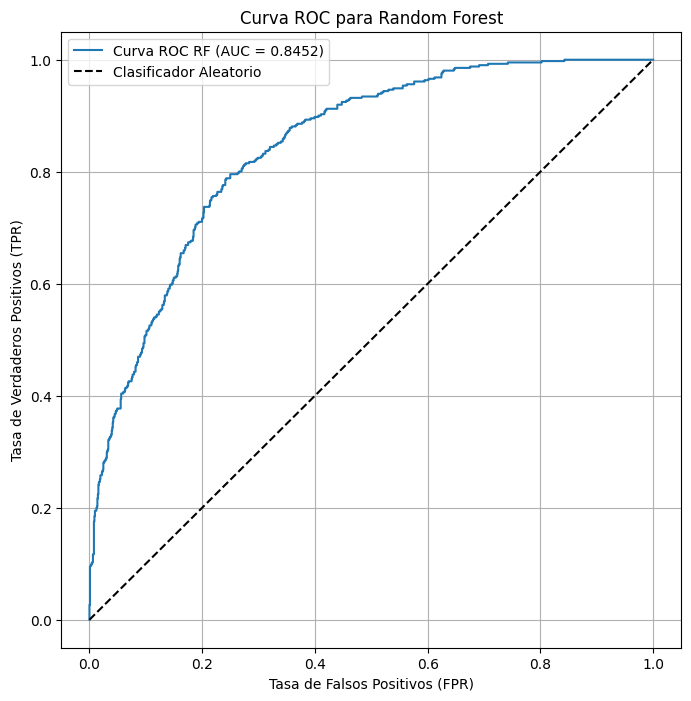

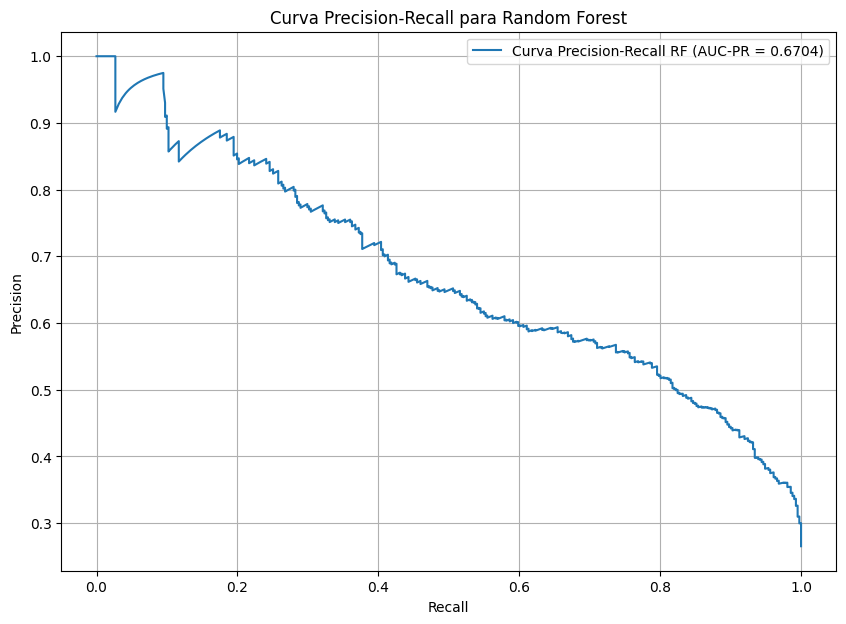


¡Entrenamiento y evaluación de Random Forest completados!


In [39]:

print("\n--- Resultados de la Búsqueda de Hiperparámetros para Random Forest---")
print(f"Mejor AUC-ROC encontrado: {grid_search_rf.best_score_:.4f}")
print(f"Mejores Hiperparámetros: {grid_search_rf.best_params_}")

# --- Evaluación del Mejor Modelo Random Forest ---
best_rf_model = grid_search_rf.best_estimator_

print("\n--- Evaluación del Mejor Modelo Random Forest en el Conjunto de Prueba---")
y_pred_proba_rf = best_rf_model.predict_proba(X_test_processed)[:, 1]
y_pred_rf = best_rf_model.predict(X_test_processed)

# Reporte de Clasificación
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred_rf))

# Matriz de Confusión
print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, y_pred_rf))

# AUC-ROC Final
auc_roc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nAUC-ROC Final del Mejor Modelo Random Forest: {auc_roc_rf:.4f}")

# --- Visualización de Curva ROC ---
fpr_rf, tpr_rf, thresholds_rf_roc = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Curva ROC RF (AUC = {auc_roc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización de Curva Precision-Recall ---
precision_rf, recall_rf, thresholds_rf_pr = precision_recall_curve(y_test, y_pred_proba_rf)
auc_pr_rf = auc(recall_rf, precision_rf)

plt.figure(figsize=(10, 7))
plt.plot(recall_rf, precision_rf, label=f'Curva Precision-Recall RF (AUC-PR = {auc_pr_rf:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall para Random Forest')
plt.legend()
plt.grid(True)
plt.show()

print("\n¡Entrenamiento y evaluación de Random Forest completados!")

Mejor F1-score: 0.6406 con umbral: 0.54


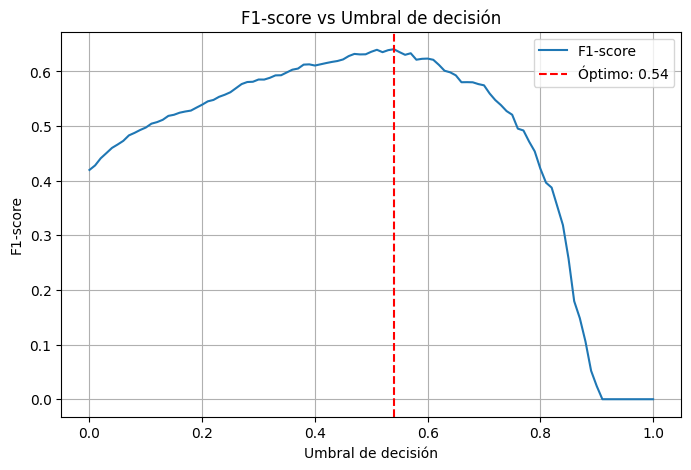

In [40]:
#import numpy as np
#from sklearn.metrics import f1_score, precision_recall_curve

# Calcula F1-score para varios umbrales
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_rf >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

# Encuentra el umbral óptimo (máximo F1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Mejor F1-score: {best_f1:.4f} con umbral: {best_threshold:.2f}")

# Grafica F1-score vs umbral
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo: {best_threshold:.2f}')
plt.xlabel('Umbral de decisión')
plt.ylabel('F1-score')
plt.title('F1-score vs Umbral de decisión')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1137
           1       0.56      0.76      0.64       411

    accuracy                           0.77      1548
   macro avg       0.73      0.77      0.74      1548
weighted avg       0.81      0.77      0.78      1548

[[888 249]
 [100 311]]


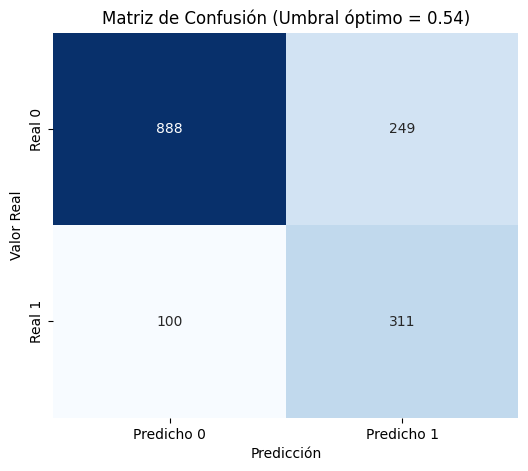

In [41]:

y_pred_rf_opt = (y_pred_proba_rf >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_rf_opt))
print(confusion_matrix(y_test, y_pred_rf_opt))

# 1. Calcula el umbral óptimo y las predicciones
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba_rf >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred_rf_opt = (y_pred_proba_rf >= best_threshold).astype(int)

# 2. Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf_opt)

# 3. Grafica la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title(f'Matriz de Confusión (Umbral óptimo = {best_threshold:.2f})')
plt.show()

In [42]:
# Obtener el mejor modelo de Random Forest encontrado por GridSearchCV
best_rf_model = grid_search_rf.best_estimator_


# Se obtiene caracteristicas despues del entranamiento
feature_names = preprocessor.get_feature_names_out()

importances = best_rf_model.feature_importances_

# Crear un DataFrame para visualizar mejor las importancias

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar las características por importancia de forma descendente
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nImportancia de las características en el mejor modelo Random Forest:")
print(feature_importances_df)


Importancia de las características en el mejor modelo Random Forest:
                                              Feature  Importance
0                                num__customer.tenure    0.184554
20                     cat__account.Contract_Two year    0.136267
1                          num__account.Charges.Total    0.131177
5           cat__internet.InternetService_Fiber optic    0.092986
22        cat__account.PaymentMethod_Electronic check    0.073213
19                     cat__account.Contract_One year    0.048779
14                      cat__internet.TechSupport_Yes    0.030604
8                    cat__internet.OnlineSecurity_Yes    0.030498
2                                  num__num_servicios    0.028479
9      cat__internet.OnlineBackup_No internet service    0.026547
6                    cat__internet.InternetService_No    0.018933
7    cat__internet.OnlineSecurity_No internet service    0.018552
13      cat__internet.TechSupport_No internet service    0.018384
28    